# Data pre-processing

This code loads the videos, extracts frames and save as ap array files on disk.

In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as datetime
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Print num of GPUs if available to use
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Set data directories and other parameters

In [3]:
# Data paths are defined here
DATA_DIR = 'data'
VIDEO_PATH = os.path.join(DATA_DIR, 'videos')
ANNOTATION_PATH = os.path.join(DATA_DIR, 'annotations')
TRAINING_PATH = os.path.join(VIDEO_PATH, 'training')
TESTING_PATH = os.path.join(VIDEO_PATH, 'testing')
VALIDATION_PATH = os.path.join(VIDEO_PATH, 'validation')

In [4]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Set a minimum duration in seconds to extract sequence in multiples of
MIN_DURATION = 150

(DIMENSION_X, DIMENSION_Y, DIMENSION_C) = (224, 224, 3)

# Get the names of all classes/categories in our dataset.
CLASSES_LIST = os.listdir(TRAINING_PATH)

Define a easily readable class name mapping

In [5]:
class_mapping = {
'_cut___chop___slice_a_vegetable,_fruit,_or_meat_' : 'cut vegetables, herbs or meat',
'browse_through_clothing_items_on_rack___shelf___hanger' : 'browse through clothing items',
'clean___wipe_other_surface_or_object' : 'clean surface',
'dig_or_till_the_soil_with_a_hoe_or_other_tool' : 'till soil with a hoe',
'read_a_book___magazine___shopping_list_etc' : 'read a book',
'throw_away_trash___put_trash_in_trash_can' : 'throw away trash',
'wash_dishes___utensils___bakeware_etc' : 'wash utensils'}

#### 1.2 Show some stills from training dataset

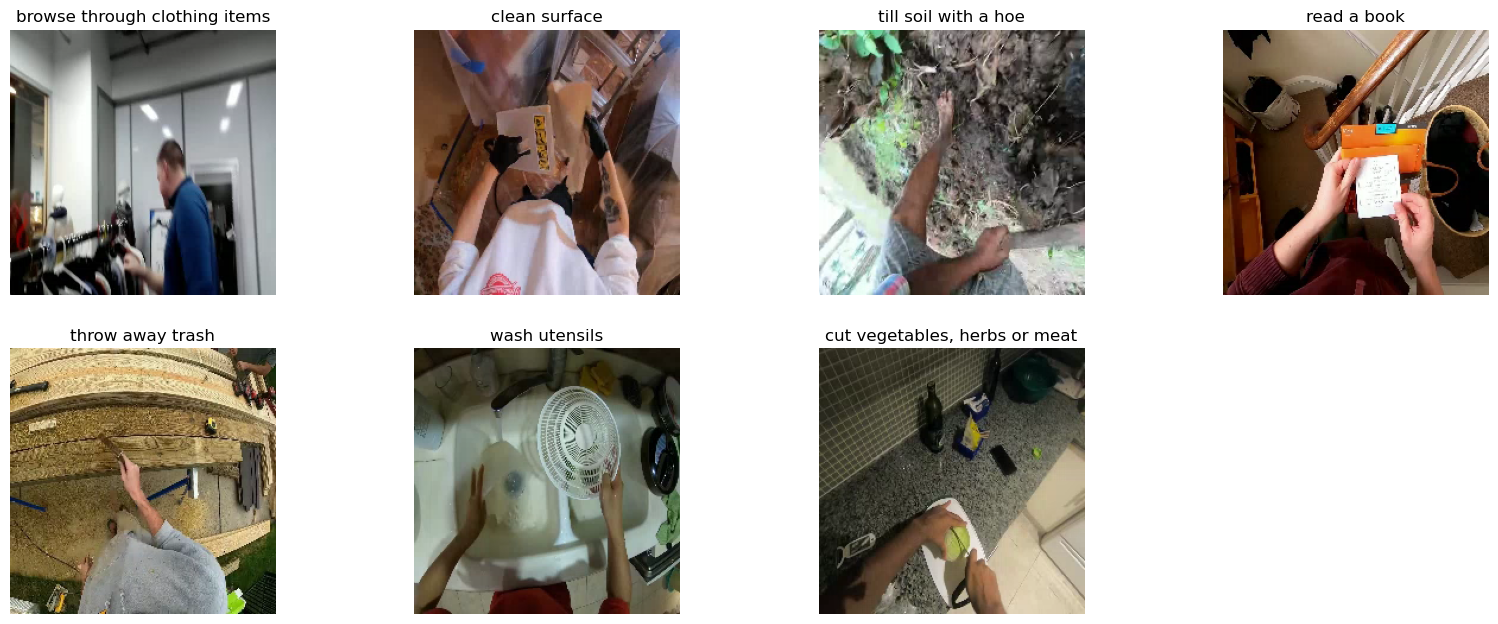

In [6]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Iterating through all the classes.
for class_name in CLASSES_LIST:
    if class_name.startswith('.'): continue
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(os.path.join(TRAINING_PATH, class_name))

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    while not selected_video_file_name.endswith('.mp4'): selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(os.path.join(TRAINING_PATH, class_name, selected_video_file_name))
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Display the frame.
    plt.subplot(5, 4, CLASSES_LIST.index(class_name) + 1).set_title(class_mapping[class_name])
    plt.imshow(rgb_frame)
    plt.axis('off')

### Read all videos, extract frams and save as nparrays 

This section should only be run once to create the nparrays for the dataset and save them to disk. The nparrays are then used in the next section to create the data generator. (**Run only once**)

The file uploaded to drive can be downloaded and unzipped to the data directory instead of running this code.

In [ ]:
from frames_extractor import video

In [ ]:
def create_dataset_on_disk(data_path):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        if class_name.startswith('.'): continue
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name} from {data_path}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(data_path, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            if not file_name.endswith('.mp4'): continue
            # Get the complete video path.
            video_file_path = os.path.join(data_path, class_name, file_name)
            vid = video(video_file_path)
            # Extract the frames of the video file.
            frames = vid.frames_extraction()

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) % SEQUENCE_LENGTH == 0:
                # Append the data to their repective lists.
                for i in range(0, len(frames), SEQUENCE_LENGTH):
                    np.save(os.path.join(data_path, class_name, 
                        f'{file_name[:-4]}_{i}.npy'), 
                        np.asarray(frames[i:i+SEQUENCE_LENGTH]))

In [ ]:
%%time
create_dataset_on_disk(TRAINING_PATH)

In [ ]:
%%time
create_dataset_on_disk(TESTING_PATH)

In [ ]:
%%time
create_dataset_on_disk(VALIDATION_PATH)

#### Code to zip npy files - no need to run

In [ ]:
from zipfile import ZipFile
zipObj = ZipFile('data_npy.zip', 'w')
for partition_path in [TRAINING_PATH, TESTING_PATH, VALIDATION_PATH]:
	for class_name in os.listdir(partition_path):
		for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
			if not video_file_name.endswith('.npy'): continue
			nparrayfile_path = os.path.join(partition_path, class_name, video_file_name)
			zipObj.write(nparrayfile_path)

# close the Zip File
zipObj.close()

Sample code to use the data generator to load videos instead of nparray files (Not required - will fail if run)

In [ ]:
from batch_data_generator import DataGenerator

In [ ]:
def get_videos_and_labels_in_partition(partition_path):
	video_paths = []
	labels = {}
	for class_name in os.listdir(partition_path):
		if class_name not in CLASSES_LIST:
			print(f'{class_name} not found in class list!')
			continue
		for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
			if not video_file_name.endswith('.mp4'): continue
			video_path = os.path.join(partition_path, class_name, video_file_name)
			video_paths.append(video_path)
			labels[video_path] = CLASSES_LIST.index(class_name)
	return video_paths, labels

Create the data generator and define parameters for training and validation data generators

In [ ]:
partition = {}
labels = {}
partition['train'], labels['train'] = get_videos_and_labels_in_partition(TRAINING_PATH)
partition['test'], labels['test'] = get_videos_and_labels_in_partition(TESTING_PATH)
partition['validation'], labels['validation'] = get_videos_and_labels_in_partition(VALIDATION_PATH)

In [ ]:
print('Number of training videos: ', len(partition['train']))
print('Number of testing videos: ', len(partition['test']))
print('Number of validation videos: ', len(partition['validation']))

In [ ]:
train_data_generator_params = {
	'load_video': True,
	'batch_size' : 80,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

validation_data_generator_params = {
	'load_video': True,
	'batch_size' : 20,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

In [ ]:
training_generator = DataGenerator(partition['train'], labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(partition['validation'], labels['validation'], **validation_data_generator_params)

To randomly use only a part of the dataset, use the following code instead

In [ ]:
part_to_use = 0.5

train_partition = np.random.choice(partition['train'], int(len(partition['train']) * part_to_use), replace = False)
val_partition = np.random.choice(partition['validation'], int(len(partition['validation']) * part_to_use), replace = False)

training_generator = DataGenerator(train_partition, labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(val_partition, labels['validation'], **validation_data_generator_params)